## Visualize Dataset

In [1]:
import os
import sys

# Needed to import modules from parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from collections import Counter
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features, load_dataset
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import random
import torch

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
topic = "cannabis" #"energie" #"kinder" "cannabis"
topics = ["energie", "kinder", "cannabis"]

In [4]:
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed")

print(dataset)
print(dataset[1])

Dataset({
    features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label'],
    num_rows: 49975
})
{'_id': '64a0946b749484eec84dbcd0', 'batch_id': 16, 'domain': 'bilendi.com', 'view_url': "surveyd.bilendi.com/survey/selfserve/53b/2306124#!'", 'lang': 'de', 'text': " Die URL oben enthält nicht die für diese Umfrage erforderlichen Informationen. Die korrekte URL finden Sie in Ihrer Einladungs-E-Mail. Wenn die Probleme weiterhin auftreten, wenden Sie sich bitte an die dort angegebene Person. ERROR: SE-02 Variable list has invalid value '' ", 'text_length': 276, 'word_count': 43, 'topic': 'cannabis', 'category': 'other', 'good_for_training': 'False', 'good_for_augmentation': 'True', 'annotation_type': 'domain_discarded', 'is_topic': False, 'label': 0}


## Load Encoder

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")#'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<00:00, 282kB/s]
README.md: 100%|██████████| 4.13k/4.13k [00:00<00:00, 3.42MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 122kB/s]
config.json: 100%|██████████| 723/723 [00:00<00:00, 1.71MB/s]
model.safetensors: 100%|██████████| 1.11G/1.11G [00:14<00:00, 74.7MB/s]
tokenizer_config.json: 100%|██████████| 402/402 [00:00<00:00, 2.49MB/s]
sentencepiece.bpe.model: 100%|██████████| 5.07M/5.07M [00:00<00:00, 63.6MB/s]
tokenizer.json: 100%|██████████| 9.08M/9.08M [00:00<00:00, 12.0MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 442kB/s]


## Get Embedding

In [7]:
# Function to encode texts to embeddings
def encode_to_embedding(example):
    example['embeddings'] = model.encode(example['text'])
    return example

# Apply the function to the dataset
encoded_dataset = dataset.map(encode_to_embedding, batched=True)


## Project Embeddings

In [8]:
embeddings = encoded_dataset['embeddings']
labels = encoded_dataset['label']

from sklearn.decomposition import PCA
import numpy as np

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings)

# Initialize PCA, reducing to 2 components
pca = PCA(n_components=2)

# Fit PCA on the embeddings and transform them
embeddings_pca = pca.fit_transform(embeddings_array)


## Plot Projection

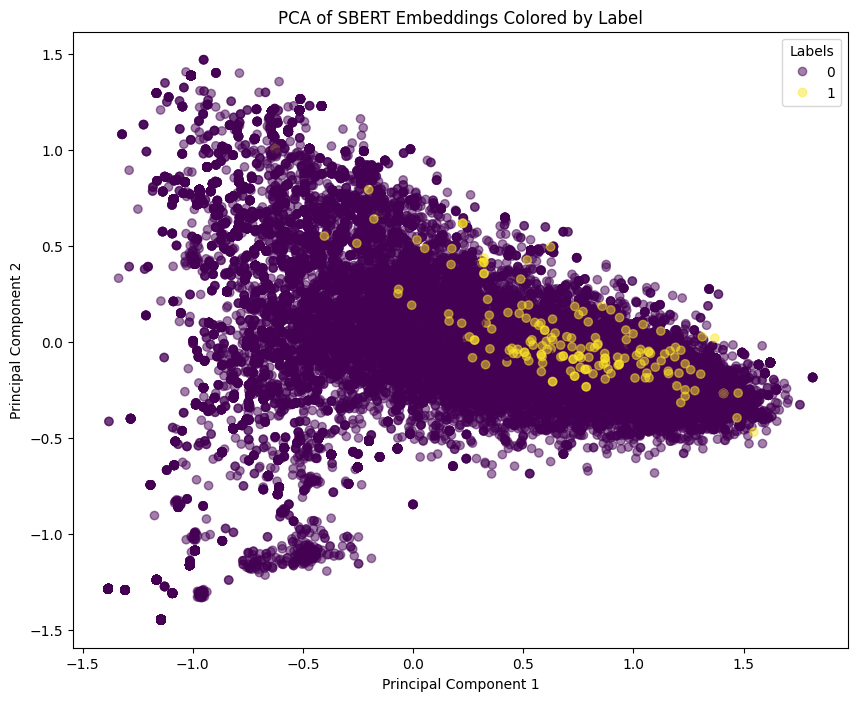

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to numerical values if they're not already numerical
# This step assumes labels are categorical and converts them to a numerical format
unique_labels = np.unique(labels)
label_to_num = {label: num for num, label in enumerate(unique_labels)}
numerical_labels = [label_to_num[label] for label in labels]

# Scatter plot of the PCA-reduced embeddings, colored by label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=numerical_labels, alpha=0.5, cmap='viridis')
plt.title('PCA of SBERT Embeddings Colored by Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a legend
handles, _ = scatter.legend_elements()
plt.legend(handles, unique_labels, title="Labels")

plt.show()


## Plot positive Examples

In [10]:
dataset = load_from_disk(f"../../data/tmp/processed_dataset_all_topics")

In [11]:
from datasets import concatenate_datasets

# Filter the dataset for positive samples
positive_samples = dataset.filter(lambda example: example['is_topic'])

# # Filter the dataset for negative samples
# negative_samples = dataset.filter(lambda example: not example['is_topic'])

# # Determine the number of negative samples you want to sample, e.g., equal to the number of positive samples
# num_samples_to_select = len(positive_samples) *10

# # If there are more negative samples than you need, randomly sample them
# if len(negative_samples) > num_samples_to_select:
#     negative_samples = negative_samples.shuffle(seed=42).select(range(num_samples_to_select))

# # Combine the positive and sampled negative samples
# combined_dataset = concatenate_datasets([positive_samples, negative_samples])

# # Output the length of the combined dataset
# len_combined = len(combined_dataset)
# len_combined


In [12]:
# Function to encode texts to embeddings
def encode_to_embedding(example):
    example['embeddings'] = model.encode(example['text'])
    return example

# Apply the function to the dataset
encoded_dataset = positive_samples.map(encode_to_embedding, batched=True)


In [13]:
embeddings = encoded_dataset['embeddings']
labels = encoded_dataset['topic']

from sklearn.decomposition import PCA
import numpy as np

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings)

# Initialize PCA, reducing to 2 components
pca = PCA(n_components=2)

# Fit PCA on the embeddings and transform them
embeddings_pca = pca.fit_transform(embeddings_array)

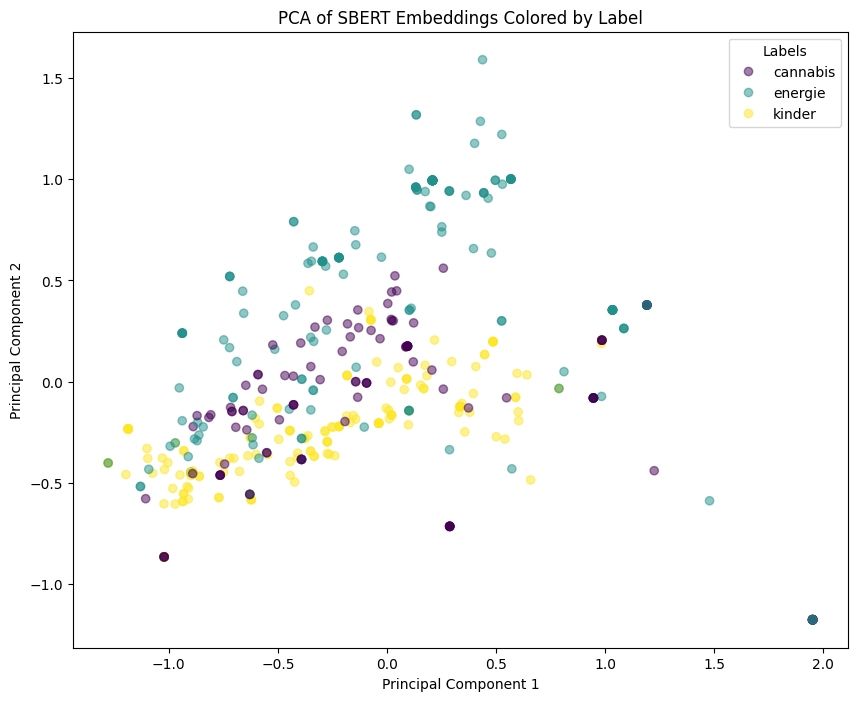

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Convert labels to numerical values if they're not already numerical
# This step assumes labels are categorical and converts them to a numerical format
unique_labels = np.unique(labels)
label_to_num = {label: num for num, label in enumerate(unique_labels)}
numerical_labels = [label_to_num[label] for label in labels]

# Scatter plot of the PCA-reduced embeddings, colored by label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=numerical_labels, alpha=0.5, cmap='viridis')
plt.title('PCA of SBERT Embeddings Colored by Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a legend
handles, _ = scatter.legend_elements()
plt.legend(handles, unique_labels, title="Labels")

plt.show()